# load library

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from catboost import CatBoostClassifier

plt.rcParams['font.family'] = 'Malgun Gothic'

# load data

In [26]:
consume_df = pd.read_csv('data\서울 시민의 소비 및 이동 패턴 재현 데이터.csv',encoding='utf-8')

In [27]:
combined_df = pd.read_csv('preprocessed data/combined_df.csv',index_col=0) #원본 데이터

# preprocessing data

In [28]:
# 1. 생년월일 숫자형으로 변환
consume_df['생년월일'] = consume_df['생년월일'].astype(int)

# 2. 현재 연도
current_year = datetime.now().year

# 3. 연령대 그룹화 함수 ✔️ 수정됨
def convert_to_age_group(birth_year):
    age = current_year - int(birth_year)
    if age >= 60:
        return '60대' #60대 이상도 60대로 할당
    age_group = (age // 10) * 10
    return f"{age_group}대"

# 4. AGE 컬럼 생성
consume_df['AGE'] = consume_df['생년월일'].apply(convert_to_age_group)
consume_df.drop(columns=['생년월일'], inplace=True)

# 5. 성별 → SEX 컬럼 전환
consume_df['SEX'] = consume_df['성별'].replace({'남': 'M', '여': 'F'})
consume_df.drop(columns=['성별'], inplace=True)

# 6. 20대 ~ 60대 이상 필터링
valid_ages = ['20대', '30대', '40대', '50대', '60대']
consume_df = consume_df[consume_df['AGE'].isin(valid_ages)].copy()


In [29]:
consume_df['INCOME'] = consume_df['추정연소득']
consume_df['INCOME'] = (consume_df['INCOME']/10)/12

def income_bin_cut(df, income_col='INCOME'):
    bins = [0, 300, 500, 700, np.inf]  # 구간 나누는 기준
    labels = [
        '300만원 미만',
        '300이상500만원 미만',
        '500이상700만원 미만',
        '700만원 이상'
    ]
    # right=False: 우측 미포함(이상/미만 커버)
    return pd.cut(df[income_col], bins=bins, labels=labels, right=False)

consume_df['INCOME'] = income_bin_cut(consume_df, income_col='INCOME')

In [30]:
consume_df[['INCOME','AGE','SEX']]

,INCOME,AGE,SEX
0,300이상500만원 미만,40대,M
1,300만원 미만,60대,M
2,300만원 미만,60대,M
3,300이상500만원 미만,40대,F
4,300만원 미만,60대,F
...,...,...,...
995,300만원 미만,60대,M
996,500이상700만원 미만,60대,M
997,300이상500만원 미만,60대,M
998,300이상500만원 미만,40대,M


# classification with pre-learned catboost model

In [7]:
#모델 불러오기
loaded_model = CatBoostClassifier()
loaded_model.load_model("model/catboost_clustering.cbm")

In [8]:
# 1. 데이터 전처리
X = consume_df[['SEX', 'AGE', 'INCOME']].dropna(axis=0)

# 2. 예측 수행
pred_y = loaded_model.predict(X)

# 3. 인덱스 추출
target_index = X.index

# 3. 예측값 컬럼 생성
consume_df.loc[target_index, 'prediction'] = pred_y

In [9]:
pred_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Re-modeling

In [14]:
test_df.to_csv('preprocessed data/catboost_clustered_df.csv')

# catboost 발표 재코딩

In [34]:
import pandas as pd
from catboost import CatBoostClassifier, Pool, cv

# -----------------------------------
# 1. 데이터 불러오기 및 병합/전처리
# -----------------------------------
k_df = pd.read_csv('preprocessed data/k_df.csv', index_col=0)
combined_df = pd.read_csv('preprocessed data/combined_df.csv', index_col=0)

# 보간된 INCOME 값 반영
combined_df.loc[k_df.index, 'INCOME'] = k_df['INCOME']

# kmeans cluster 0를 binary로 라벨링
cluster0_indices = k_df[k_df['kmeans_cluster'] == 0].index
combined_df['kmeans_cluster'] = combined_df.index.isin(cluster0_indices).astype(int)

# 서울특별시로 필터링
combined_df = combined_df[combined_df['AREA'] == '서울특별시']

# 훈련용 변수 설정
train_df = combined_df[['SEX', 'AGE', 'INCOME', 'kmeans_cluster']]
X = train_df.drop('kmeans_cluster', axis=1)
y = train_df['kmeans_cluster']
cat_features = ['SEX', 'AGE', 'INCOME']

# -----------------------------------
# 2. 테스트 데이터 준비
# -----------------------------------

X_test = consume_df[['SEX', 'AGE', 'INCOME']].dropna()
X_test_indices = X_test.index  # 나중 정렬을 위해 저장

# -----------------------------------
# 3. CatBoost용 Pool 생성
# -----------------------------------
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# -----------------------------------
# 4. 교차 검증으로 최적 반복 횟수 찾기
# -----------------------------------
cv_params = {
    'iterations': 1000,
    'learning_rate': 0.2,
    'loss_function': 'Logloss',
    'early_stopping_rounds': 50,
    'verbose': False,
    'random_seed': 42
}

cv_results = cv(
    params=cv_params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    stratified=True,
    partition_random_seed=42
)

# 최적 반복수 선택
best_iteration = cv_results['test-Logloss-mean'].idxmin()
print("✅ Best iteration:", best_iteration)

# -----------------------------------
# 5. 최종 모델 학습
# -----------------------------------
final_model = CatBoostClassifier(
    iterations=best_iteration,
    learning_rate=0.2,
    loss_function='Logloss',
    cat_features=cat_features,
    verbose=False,
    random_seed=42
)
final_model.fit(X, y)

# -----------------------------------
# 6. 예측 수행 (threshold 0.005)
# -----------------------------------
# 확률 예측 (클러스터 0일 확률)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# threshold = 0.005 기준 분류
threshold = 0.005
y_pred_class = (y_pred_proba >= threshold).astype(int)

# -----------------------------------
# 7. 결과 정리
# -----------------------------------
test_df = consume_df.loc[X_test_indices].copy()
test_df['cluster0_prob'] = y_pred_proba
test_df['cluster0_class'] = y_pred_class

# 출력
print("🔍 예측 결과 (Top 10):")
print(test_df[['SEX', 'AGE', 'INCOME', 'cluster0_prob', 'cluster0_class']].head(10))
print(test_df['cluster0_class'].value_counts())

# Optional: 파일 저장
# test_df.to_csv('prediction_results_catboost.csv', index=False, encoding='utf-8-sig')


Training on fold [0/5]

bestTest = 0.07304319338
bestIteration = 28

Training on fold [1/5]

bestTest = 0.06833921297
bestIteration = 11

Training on fold [2/5]

bestTest = 0.06491951597
bestIteration = 71

Training on fold [3/5]

bestTest = 0.06727755103
bestIteration = 27

Training on fold [4/5]

bestTest = 0.05948799055
bestIteration = 30

✅ Best iteration: 28
🔍 예측 결과 (Top 10):
  SEX  AGE         INCOME  cluster0_prob  cluster0_class
0   M  40대  300이상500만원 미만       0.004294               0
1   M  60대       300만원 미만       0.004294               0
2   M  60대       300만원 미만       0.004294               0
3   F  40대  300이상500만원 미만       0.005869               1
4   F  60대       300만원 미만       0.005869               1
5   M  20대       700만원 이상       0.004636               0
6   F  60대       300만원 미만       0.005869               1
7   M  50대  300이상500만원 미만       0.004294               0
8   M  40대       700만원 이상       0.004294               0
9   M  40대  500이상700만원 미만       0.010232      

In [35]:
from sklearn.metrics import (
    log_loss, accuracy_score, roc_auc_score,
    average_precision_score
)

# ----------------------------
# 8. 모델 평가 (훈련 데이터 기준)
# ----------------------------

# 예측 확률 (훈련 데이터 기준)
y_train_pred_proba = final_model.predict_proba(X)[:, 1]
y_train_pred = (y_train_pred_proba >= 0.5).astype(int)

# ▶ 평가 지표 계산
logloss = log_loss(y, y_train_pred_proba)
accuracy = accuracy_score(y, y_train_pred)
auc = roc_auc_score(y, y_train_pred_proba)
ap = average_precision_score(y, y_train_pred_proba)

# ▶ 출력
print(f"\n📊 CatBoost 모델 평가 지표 (Train set)")
print(f"Logloss:           {logloss:.4f}")
print(f"정확도(Accuracy):   {accuracy:.4f}")
print(f"AUC:               {auc:.4f}")
print(f"Average Precision: {ap:.4f}")



📊 CatBoost 모델 평가 지표 (Train set)
Logloss:           0.0718
정확도(Accuracy):   0.9611
AUC:               0.9710
Average Precision: 0.4200


# logistic regression


★ 1이 100명 이상 되도록 하는 threshold: 0.005156
  SEX  AGE         INCOME  cluster0_prob  cluster0_class
0   M  40대  300이상500만원 미만       0.000028               0
1   M  60대       300만원 미만       0.000030               0
2   M  60대       300만원 미만       0.000030               0
3   F  40대  300이상500만원 미만       0.002911               0
4   F  60대       300만원 미만       0.003142               0
5   M  20대       700만원 이상       0.000034               0
6   F  60대       300만원 미만       0.003142               0
7   M  50대  300이상500만원 미만       0.000027               0
8   M  40대       700만원 이상       0.000021               0
9   M  40대  500이상700만원 미만       0.005430               1
cluster0_class
0    845
1    106
Name: count, dtype: int64

Logloss:  0.0680
정확도:   0.9611
AUC:      0.9713
Average Precision: 0.4308
                 feature  coefficient
9   INCOME_500이상700만원 미만     4.279051
1                  SEX_M    -2.322859
0                  SEX_F     2.322269
10       INCOME_700만원 이상    -1.263352
11      

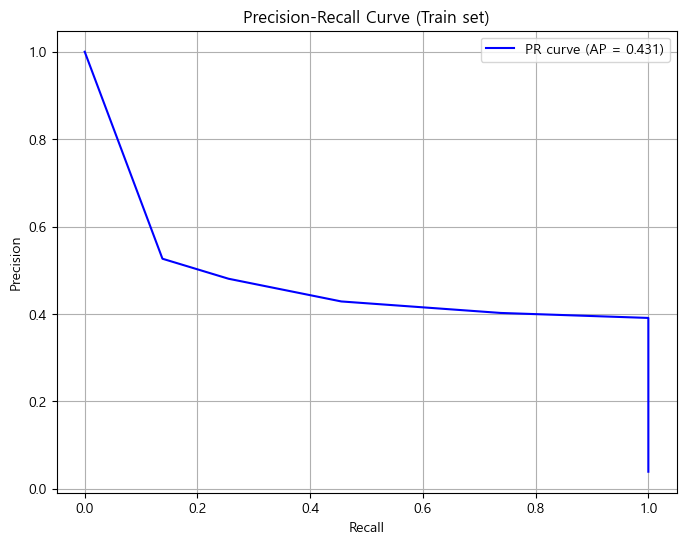

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    log_loss, accuracy_score, roc_auc_score,
    f1_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 전처리
k_df = pd.read_csv('preprocessed data/k_df.csv', index_col=0)
combined_df = pd.read_csv('preprocessed data/combined_df.csv', index_col=0)

combined_df.loc[k_df.index, 'INCOME'] = k_df['INCOME']
cluster0_indices = k_df[k_df['kmeans_cluster'] == 0].index
combined_df['kmeans_cluster'] = combined_df.index.isin(cluster0_indices).astype(int)
combined_df = combined_df[combined_df['AREA'] == '서울특별시']

feature_cols = ['SEX', 'AGE', 'INCOME']
X = combined_df[feature_cols]
y = combined_df['kmeans_cluster']

# 2. 원-핫 인코딩
ohe = OneHotEncoder(handle_unknown='ignore')
X_encoded = ohe.fit_transform(X)

# 3. 테스트 데이터 준비 및 인코딩
X_test = consume_df[feature_cols].dropna(axis=0)
X_test_encoded = ohe.transform(X_test)

# 4. 모델 학습
model_lr = LogisticRegression(max_iter=200, random_state=42)
model_lr.fit(X_encoded, y)

# 5. 테스트 예측(확률)
y_pred_proba = model_lr.predict_proba(X_test_encoded)[:, 1]

# 6. cluster0_class = 1이 100명 이상 되도록 threshold 자동 지정
target_count = 100
sorted_probs = np.sort(y_pred_proba)[::-1]
if len(sorted_probs) >= target_count:
    new_threshold = sorted_probs[target_count-1]
else:
    new_threshold = sorted_probs[-1]
print(f"\n★ 1이 100명 이상 되도록 하는 threshold: {new_threshold:.6f}")

y_pred_class_for100 = (y_pred_proba >= new_threshold).astype(int)

# 7. 결과 정리
test_df = consume_df.loc[X_test.index].copy()
test_df['cluster0_prob'] = y_pred_proba
test_df['cluster0_class'] = y_pred_class_for100

print(test_df[['SEX', 'AGE', 'INCOME', 'cluster0_prob', 'cluster0_class']].head(10))
print(test_df['cluster0_class'].value_counts())

# 8. 학습 데이터 기준 성능 평가 및 feature 영향력
y_val_proba = model_lr.predict_proba(X_encoded)[:, 1]
logloss = log_loss(y, y_val_proba)
accuracy = accuracy_score(y, (y_val_proba >= 0.5).astype(int))
auc = roc_auc_score(y, y_val_proba)
ap = average_precision_score(y, y_val_proba)

print(f"\nLogloss:  {logloss:.4f}")
print(f"정확도:   {accuracy:.4f}")
print(f"AUC:      {auc:.4f}")
print(f"Average Precision: {ap:.4f}")

feature_names = ohe.get_feature_names_out(feature_cols)
coef = model_lr.coef_[0]
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)
print(feature_importance_df[['feature', 'coefficient']])

# 9. PR 곡선 시각화
precision, recall, thresholds = precision_recall_curve(y, y_val_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.3f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Train set)')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
test_df.drop(['prediction','cluster0_prob'],axis=1,inplace=True)

In [17]:
test_df.rename(columns={'cluster0_class': 'logistic_cluster'}, inplace=True)


In [18]:
test_df

,자치구명,동일세대_학령기인구수,동일세대_미취학아동수,직업군,평균_문자대상자수,평균_통화대상자수,평균_통화량,세대주여부,1인가구여부,주택보유여부,...,평일_이동속도_평균,휴일_총이동거리,휴일_이동속도_평균,택시이용_이동횟수,네비게이션이용_이동횟수,지하철_이동일수,AGE,SEX,INCOME,logistic_cluster
0,강동구,3,0,420,NaN,NaN,NaN,세대주,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,40대,M,300이상500만원 미만,0
1,도봉구,2,0,420,NaN,NaN,NaN,세대주,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,60대,M,300만원 미만,0
2,동작구,2,0,420,NaN,NaN,NaN,세대주,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,60대,M,300만원 미만,0
3,동대문구,2,0,420,NaN,NaN,NaN,세대주,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,40대,F,300이상500만원 미만,0
4,서초구,0,0,420,28.0,6.0,91.0,세대주,0,1,...,31.0,470.0,39.0,0.0,0.0,9.0,60대,F,300만원 미만,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,서초구,1,0,510,NaN,NaN,NaN,세대주,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,60대,M,300만원 미만,0
996,강남구,0,0,440,120.0,45.0,1000.0,세대주,0,0,...,48.0,5700.0,79.0,23.0,100.0,150.0,60대,M,500이상700만원 미만,1
997,구로구,0,0,510,76.0,15.0,160.0,세대주,0,1,...,30.0,2900.0,39.0,84.0,38.0,190.0,60대,M,300이상500만원 미만,0
998,마포구,3,1,510,NaN,NaN,NaN,세대주,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,40대,M,300이상500만원 미만,0


In [19]:
test_df.to_csv('preprocessed data/logistic_clustered_df')